<a href="https://colab.research.google.com/github/evlko/CS-224W/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyvis

In [2]:
# Utils
from datetime import datetime
from collections import Counter, defaultdict
from typing import List
import math
import os

# Data 
import pandas as pd
import numpy as np

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# Graphs
from IPython.core.display import display, HTML
from pyvis.network import Network
import requests
import networkx as nx

# Clusterization
import community.community_louvain as community_louvain

# Consts

Константы, которые используются в функциях.

In [3]:
api_token = '00f5844000f5844000f58440e503e76127000f500f5844064f5112345ea184aa4e49615'
api_link = 'https://api.vk.com/method/'

In [4]:
api = {
  'access_token': api_token,
  'v': 5.131,
}

# Classes

In [5]:
class Group:
  """Group class which has id, posts and members dataframes."""
  id = 0
  posts_df = pd.DataFrame()
  members_df = pd.DataFrame()

  def __init__(self, id: int):
    self.id = id
    self.posts_df = pd.DataFrame()
    self.member_df = pd.DataFrame()
  
  def parse_unix_posts(self) -> None:
    """Cast post date format from unix style to datetime."""
    self.posts_df['date'] = self.posts_df['date'].apply(lambda x: datetime.fromtimestamp(x))

  def get_hasttags_from_posts(self) -> dict:
    """Get dict of hashtags from all group's posts, where key is a hashtag and value its frequency."""
    hashtags_df = pd.DataFrame()
    hashtags_df['hashtags'] = self.posts_df['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
    hashtags = [hashtag for text_hashtags in hashtags_df['hashtags'].tolist() for hashtag in text_hashtags]
    return dict(Counter(hashtags))

  def set_posts_df(self, posts) -> None:
    """Set group's post dataframe. Posts can be a list or dataframe."""
    self.posts_df = pd.DataFrame(posts)[['id', 'text', 'date', 'likes', 'reposts']]
    for col in ['likes', 'reposts']:
      self.posts_df[col] = self.posts_df[col].apply(pd.Series)['count']
    self.posts_df['meme'] = np.where(self.posts_df['text'].str.len() == 0, 1, 0)

    self.parse_unix_posts()
  
  def set_members_df(self, users) -> None:
    """Set group's members dataframe. Users can be a list or dataframe."""
    self.members_df = pd.DataFrame(users)

# Functions

## Utils

In [6]:
def find_intersection(sets: List[list]) -> list:
  """Return intersection of several lists."""
  sets_intersection = set(sets[0])
  for s in sets:
    sets_intersection = sets_intersection.intersection(s)
  return sets_intersection

In [7]:
def find_union(sets: List[list]) -> list:
  """Return union of several lists."""
  sets_union = set(sets[0])
  for s in sets:
    sets_union = sets_union.union(s)
  return sets_union

In [8]:
def save_df_with_date(df: pd.DataFrame, name: str) -> None:
  """Save dataframe with the given name and current day to day's folder."""
  today = datetime.today().strftime('%Y_%m_%d')
  path = 'data/' + today + '/'
  os.makedirs(path, exist_ok = True)  
  df.to_csv(path + today + '_' + name + '.csv', index=False)  

## API

### VK Scripts

Вместо использования "прямых запросов" к API VK можно использоваться execute, который принимает код на языке *VK Script*, что позволяет увеличить скорость запросов в 8 раз.

https://dev.vk.com/execute

Все VK scripts записаны в словарь.

**NB**. Для удобства все строки форматируются, то есть в них подставляются нужные параметры при вызове. Сл-но, функционально блоковые скобки должны дублироваться (`{` -> `{{`).

In [9]:
vk_scripts = {
  'get_group_members': """
    var members = [];
    var offset = {o};
    var group_id = '{id}';
    
    var batch = 0;
    while (batch < 25) {{
      members.push(API.groups.getMembers({{"group_id": group_id, "offset": offset}}).items);
      offset = offset + 1000;
      batch = batch + 1;
    }}

    return members;
    """,
  'get_wall_posts': """
    var posts = [];
    var offset = 0;
    var group_id = '{id}';
    var count = 1;

    while (offset < 2000) {{
        var result = API.wall.get({{"domain": group_id, "offset": offset, "count": 100}});
        count = result.count;
        posts.push(result.items);
        offset = offset + 100;
    }}

    return posts;
    """,
  'get_user_friends': """
    var friends = [];
    var users = {u};

    var i = 0;

    while (i < users.length) {{
      var result = API.friends.get({{user_id: users[i], count: 5000}});
      friends.push(result.items);
      i = i + 1;
    }}

    return friends;
    """
}

### Requests

In [10]:
def get_json_from_api(api_method: str, api_params: dict):
  """Main method to get responses from VK API."""
  api_params = {**api, **api_params}
  try:
    return requests.get(api_link+api_method, params=api_params).json()['response']
  except:
    return None

In [11]:
def get_execute(code):
  api_method = 'execute'

  api_params = {
      'code': code
  }

  return get_json_from_api(api_method, api_params)

In [12]:
def get_group_members_batches(group_id):
  api_method = 'groups.getMembers'

  api_params = {
      'group_id': group_id,
  }

  return math.ceil(get_json_from_api(api_method, api_params)['count'] / 25000)

In [13]:
def get_group_members(group_id, executes):
  members = []
  temp_script = vk_scripts['get_group_members']

  for execute in range(executes):
    vk_script = temp_script.format(o=execute * 25000, id=group_id)
    response = get_execute(vk_script)
    for batch in response:
      members += batch

  return members

In [14]:
def get_group_posts(group_id):
  posts = []
  vk_script = vk_scripts['get_wall_posts'].format(id=group_id)
  response = get_execute(vk_script)
  for batch in response:
    posts += batch

  return posts

In [15]:
def get_users_friends(users):
  user_friends = {}
  friends = []
  temp_script = vk_scripts['get_user_friends']

  user_batches = math.ceil(len(users) / 25)
  for batch in range(user_batches):
    vk_script = temp_script.format(u=users[(25 * batch):(25 * (batch + 1))])
    friends += get_execute(vk_script)

  for i, user in enumerate(users):
    user_friends[user] = friends[i]

  return user_friends

# Analysis

## Task 1-2: Members & Posts


1. Выбрать сообщества;
2. Получить участников каждого сообщества;
3. Получить последние 2000 постов каждого сообщества.







In [16]:
group_ids = ['mathcontent', 'publicepsilon777'] # список с нужными группами
groups = []

for id in group_ids:
  groups.append(Group(id))

In [17]:
for group in groups:
  group.set_members_df(get_group_members(group.id, get_group_members_batches(group.id)))
  group.set_posts_df(get_group_posts(group.id))

При желании можно сохранить данные в `csv`, чтобы не обращаться каждый раз к API или сравнивать данные во времени:

In [18]:
for group in groups:
  save_df_with_date(group.posts_df, group.id + '_posts')
  save_df_with_date(group.members_df, group.id + '_members')

Пересечение участников в группах:

In [19]:
len(find_intersection([g.members_df[0].to_list() for g in groups]))

10504

## Task 3: Hashtags
1. Получить хэштеги из постов каждого сообщества;
2. Визуализировать;
3. Проверить хэштеги на пересечения

In [ ]:
hashtags = []

for group in groups:
  hashtags_group = group.get_hasttags_from_posts()
  hashtags.append(hashtags_group)

Пересечение хэштегов в группах:

In [ ]:
len(find_intersection([h.keys() for h in hashtags]))

0

### Визуализация

In [ ]:
for i, g in enumerate(groups):
  hashtags[i]['source'] = g.id

hashtags_df = pd.DataFrame(hashtags).melt(id_vars=['source'], var_name='cols', value_name='vals')

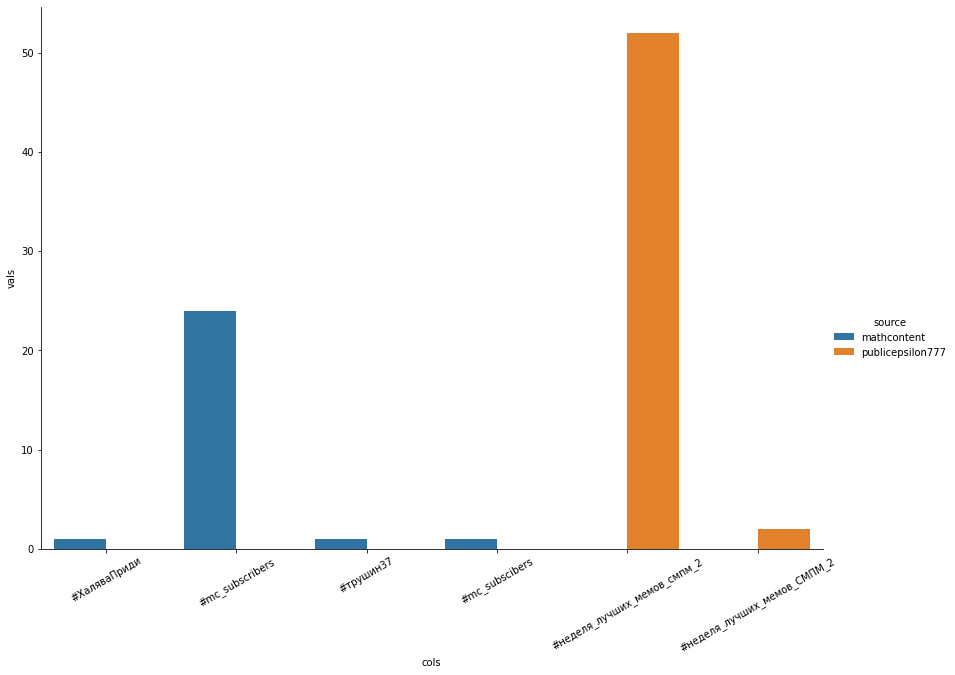

In [ ]:
g = sns.catplot(data=hashtags_df, x="cols", y="vals", hue='source', kind="bar", ci=False, height=8.27, aspect=11.7/8.27)
_ = plt.xticks(rotation=30)

### Выводы:
1. Группы используют совершенно разные хэштеги;
2. Вторая группа (`publicepsilon777`) активнее использует хэштеги.

## Task 4: Time

1. Посчитать количество постов за каждый час суток для обоих сообществ;
2. Визуализировать результаты;
3. В какое время суток наиболее активны участники социальных групп? Совпадают ли часы с наибольшей активностью для обоих сообществ?

In [ ]:
time_df = pd.DataFrame()

for group in groups:
  temp_df = pd.DataFrame()
  temp_df['hour'] = group.posts_df['date'].apply(lambda x: x.hour)  
  temp_df['source'] = group.id
  time_df = pd.concat([time_df, temp_df])

time_df = pd.DataFrame(time_df.groupby(by=['source', 'hour']).size()).reset_index().rename(columns={0: 'count'})

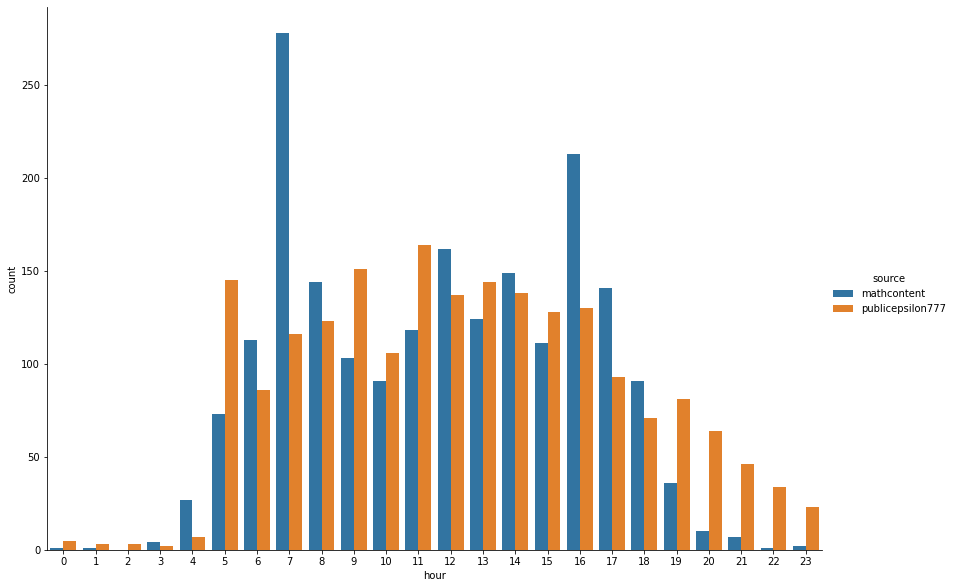

In [ ]:
sns.catplot(data=time_df, x='hour', y='count', hue='source', kind='bar', ci=False, height=8.27, aspect=11.7/8.27)

### Выводы:
1. У первой группы (`mathcontent`) наблюдаются 2 явных пика: 7 и 16 часов;
2. У второй группы (`publicepsilon777`) большая дисперсия времени, например, есть активность вечером (19-23). 

## Task 5-7: соц графчик 😎

1. Построить социальных граф сообществ;
2. При помощи кластеризации выделите сообщества внутри обоих графов.

In [20]:
# объединим участников обоих сообществ в один dataframe, где будет дополнительно помечено, явл-ся ли человек участником сообщества (1) или нет (0)
groups_members_dfs = []

for group in groups:
  group_members_df = group.members_df
  group_members_df['group' + group.id] = 1
  group_members_df = group_members_df.set_index(0)
  groups_members_dfs.append(group_members_df)

users_df = pd.concat(groups_members_dfs, axis=1).fillna(0)
users_df.index.names = ['user_id']
users_df = users_df.reset_index()

Оперировать всеми пользователями несколько сложно, поэтому возьмем случайную выборку:

In [21]:
random_users_df = users_df.sample(n=10000, random_state=42)
friends_dict = get_users_friends(random_users_df['user_id'].to_list())
random_users_df['friends'] = random_users_df['user_id'].apply(lambda x:  friends_dict[x])

friends_df = random_users_df.explode('friends').dropna()[['user_id', 'friends']]

Оставим только связи внутри сообщества

In [22]:
friends_df['community'] = friends_df['friends'].apply(lambda x: 1 if x in friends_dict.keys() else 0)
friends_df = friends_df.loc[friends_df['community'] == 1]

При желании можно сохранить данные в `csv`

In [59]:
save_df_with_date(friends_df, 'friends_connections')

Построим соц. граф

In [23]:
G = nx.from_pandas_edgelist(friends_df, source='user_id', target='friends').to_undirected()

Кол-во узлов в графе:

In [24]:
G.number_of_nodes()

4087

Кол-во ребер в графе:

In [25]:
G.number_of_edges()

4619

В класстеризации были рассмотрены варианты: спектральная класстеризация, Алгоритм Гирван — Ньюмена и Метод Лувена. Было принятно решение, что последний подходит лучше всего, так как считать матрицы при таком количестве данных не самое оптимальное решение 🙃

### Кластеризация

In [26]:
communites = community_louvain.best_partition(G)

Всего сообществ (кластеров) было выделено:

In [27]:
len(set(communites.values()))

626

Среднее кол-во людей в сообщества:

In [44]:
round(4096 / len(set(communites.values())))

7

### Визуализация

Добавим в графе аттрибут группы (сообщества)

In [28]:
friends_df['community_id'] = friends_df['user_id'].apply(lambda x: communites[x])

nx.set_node_attributes(G, communites, 'group')

Финальная визуализация

In [29]:
nt = Network(height='600px', width='900px', notebook=True, cdn_resources='in_line', bgcolor='#222222', font_color='white')
nt.from_nx(G)

nt.show_buttons(filter_=['physics'])
nt.show('social_graph.html')
display(HTML('social_graph.html'))

social_graph.html


### Выводы
1. Средний размер кластера довольно большой, вероятно, это обусловлено тем, что у кого-то есть очень много друзей, а также что не проверяются друзья-друзей;
2. Есть некоторое плотное кол-во сообществ. Вероятно, это активная аудитория сообществ;
3. Вероятно сообщества образованы группами из вузов.